# BG for Chignolin

Use the `bgflow` branch `factory`.

In [1]:
from tqdm.auto import tqdm
import time
from torch.optim.lr_scheduler import ExponentialLR
import ipywidgets as widgets
import ipdb

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

import torch

ctx = {
    "device": torch.device("cuda:0") if torch.cuda.is_available else torch.device("cpu"),
    "dtype": torch.float32
}
ctx

In [3]:
import torch

ctx = {
    "device": torch.device("cpu"),#torch.device("cuda:0") if torch.cuda.is_available else torch.device("cpu"),
    "dtype": torch.float32
}
ctx

{'device': device(type='cpu'), 'dtype': torch.float32}

In [8]:
import pandas

pandas.set_option("display.max_rows", None)

def compute_phi_psi(traj):
    """Compute backbone dihedrals.

    Parameters
    ----------
    traj : mdtraj.Trajectory
    """
    phi_atoms = [25,27,29,46]
    phi = md.compute_dihedrals(traj, indices=[phi_atoms])[:, 0]
    psi_atoms = [27,29,46,48]
    psi = md.compute_dihedrals(traj, indices=[psi_atoms])[:, 0]
    return phi, psi
import bgmol
import numpy as np
import mdtraj as md 
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import nglview as nv

def plot_phi_psi(ax, trajectory, system):
    if not isinstance(trajectory, md.Trajectory):
        trajectory = md.Trajectory(
            xyz=trajectory.reshape(-1, 175, 3), 
            topology=system.mdtraj_topology
        )
    phi, psi = compute_phi_psi(trajectory)
    
    ax.hist2d(phi, psi, 50, norm=LogNorm())
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi, np.pi)
    ax.set_xlabel("$\phi$")
    _ = ax.set_ylabel("$\psi$")
    
    return trajectory
def plot_energies_zoom(ax, samples, target_energy, test_data):
    sample_energies = target_energy.energy(torch.Tensor(samples)).numpy()
    md_energies = target_energy.energy(torch.Tensor(test_data[:len(samples)])).cpu().detach().numpy()
    cut = max(np.percentile(sample_energies, 80), 20)
    
    ax.set_xlabel("Energy   [$k_B T$]")
    # y-axis on the right
    ax2 = plt.twinx(ax)
    ax.get_yaxis().set_visible(False)
    
    ax2.hist(sample_energies, range=(-50, cut), bins=40, density=False, label="BG")
    ax2.hist(md_energies, range=(-50, cut), bins=40, density=False, label="MD")
    ax2.set_ylabel(f"Count   [#Samples / {len(samples)}]")
    ax2.legend()
    ax2.set_xlim([-50, 100])

def plot_energies(ax, samples, target_energy, test_data):
    sample_energies = target_energy.energy(torch.Tensor(samples)).numpy()
    md_energies = target_energy.energy(torch.Tensor(test_data[:len(samples)])).cpu().detach().numpy()
    cut = max(np.percentile(sample_energies, 80), 20)
    
    ax.set_xlabel("Energy   [$k_B T$]")
    # y-axis on the right
    ax2 = plt.twinx(ax)
    ax.get_yaxis().set_visible(False)
    
    ax2.hist(sample_energies, range=(-50, cut), bins=40, density=False, label="BG")
    ax2.hist(md_energies, range=(-50, cut), bins=40, density=False, label="MD")
    ax2.set_ylabel(f"Count   [#Samples / {len(samples)}]")
    ax2.legend()

def angle_marginal_estimate_complement(
        system,
        angles,
        coordinate_transform,
        temperature,
        min_angle=0.05,
        max_angle=None,
        device=torch.device("cpu"),
        dtype=torch.get_default_dtype()
):
    """Estimate the marginal distribution of angles
    from force field parameters.
    Parameters
    ----------
    system : openmm.System
        The openmm system that contains all information about the energy function and constraints.
    coordinate_transform : bgflow CoordinateTransformation
    temperature : float
        Temperature in Kelvin.
    min_angle : float, optional
        The minimum angle of the returned distribution.
    max_angle : float, optional
        The maximum angle of the returned distribution.
    device : torch.device, optional
        The device on which the returned distribution operates.
    dtype : torch.dtype, optional
        The data type on which the returned distribution operates.
    Returns
    -------
    distribution : bgflow.TruncatedNormalDistribution
        The estimated marginal distribution of angles.
        If the coordinate transform produces normalized angles in [0,1],
        the marginal distribution will produce normalized angles, too.
    """
    import bgflow as bg
    if max_angle is None:
        max_angle = 1.0 if coordinate_transform.normalize_angles else np.pi
    angles = angles
    equilibria, force_constants = bgmol.util.ff.lookup_angles(system, angles, temperature=temperature)
    if coordinate_transform.normalize_angles:
        equilibria = equilibria / np.pi
        force_constants = force_constants * np.pi**2
    sigma = 1.0 / np.sqrt(force_constants)
    distribution = bg.TruncatedNormalDistribution(
        mu=torch.tensor(equilibria, device=device, dtype=dtype),
        sigma=torch.tensor(sigma, device=device, dtype=dtype),
        lower_bound=torch.tensor(min_angle, device=device, dtype=dtype),
        upper_bound=torch.tensor(max_angle, device=device, dtype=dtype)
    )
    _mu = distribution._buffers["_mu"].item()
    _logsigma = distribution._buffers["_logsigma"].item()
    return _mu, _logsigma

In [9]:
def unnormalized_kl_div_U(prior, flow, target, n_samples, temperature=1.0):
    z = prior.sample(n_samples, temperature=temperature)
    if isinstance(z, torch.Tensor):
        z = (z,)
    *x, dlogp = flow(*z, temperature=temperature)
    return target.energy(*x, temperature=temperature)
def unnormalized_kl_div_H(prior, flow, target, n_samples, temperature=1.0):
    z = prior.sample(n_samples, temperature=temperature)
    if isinstance(z, torch.Tensor):
        z = (z,)
    *x, dlogp = flow(*z, temperature=temperature)
    return  - dlogp


## Read Dataset and System

In [10]:
from bgmol.datasets import chignolin

In [18]:
from bgmol.zmatrix import ZMatrixFactory
import os

is_data_here = os.path.isdir("/srv/public/kraemea88/projects/bg_chignolin2")
dataset = chignolin.ChignolinOBC2PT(read=True, download=True)
#dataset = ChignolinOBC2PT(read=True, download=(not is_data_here))
system = dataset.system

Using downloaded and verified file: /home/marcel/Documents/krämer/bgflow/notebooks/ChignolinOBC2PT.tgz
Extracting /home/marcel/Documents/krämer/bgflow/notebooks/ChignolinOBC2PT.tgz to /home/marcel/Documents/krämer/bgflow/notebooks
Using downloaded and verified file: /tmp/parameters_ak_dihefix.prm
Using downloaded and verified file: /tmp/structure.pdb
Using downloaded and verified file: /tmp/structure.psf
Using downloaded and verified file: /tmp/top_all22star_prot.rtf
Using downloaded and verified file: /tmp/top_water_ions.rtf
Using downloaded and verified file: /tmp/chignolin_tica.npz


In [19]:
target_real = dataset.get_energy_model(n_workers=6)

In [20]:
import bgflow as bg
target = bg.LinLogCutEnergy(dataset.get_energy_model(n_workers=6), high_energy=100., max_energy=1000.)

trajectory = dataset.trajectory
trajectory.superpose(trajectory)
data = trajectory.xyz.reshape(len(dataset), -1)

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import mdtraj as md
import nglview as nv
from bgflow.utils import as_numpy

def show_structures(traj, top=system.mdtraj_topology):
    if not isinstance(traj, md.Trajectory):
        n_samples = traj.shape[0]
        traj = md.Trajectory(traj.reshape(n_samples, -1, 3), topology=top)
    traj.superpose(traj)
    widget = nv.show_mdtraj(traj)
    widget.add_representation("licorice")
    return widget
    
def plot_tics(xyz, ax, system=system, lims=((-1.5, 2), (-1.5, 3.5))):
    n_samples = xyz.shape[0]
    xyz = as_numpy(xyz.reshape(n_samples, -1))
    tics = system.to_tics(xyz)
    
    ax.hist2d(
        tics[:,0], tics[:,1], 
        bins=100,
        range=lims, 
        norm=LogNorm(vmax=10, vmin=1e-4),
        density=True
    )
    ax.set_xlabel("TIC1")
    ax.set_ylabel("TIC2")
    ax.set_xlim(*lims[0])
    ax.set_ylim(*lims[1])

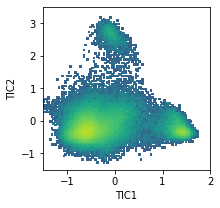

In [21]:
fig, ax = plt.subplots(figsize=(3,3))
plot_tics(data, ax)
wid=show_structures(data)

## Build Coordinate Transform

In [27]:
USE_MIXED = False

if USE_MIXED:

    factory = ZMatrixFactory(system.mdtraj_topology, cartesian="backbone and (element C or element N)")
    zmatrix, fixed_atoms = factory.build_with_templates()

    coordinate_transform = bg.MixedCoordinateTransformation(
        z_matrix=zmatrix,
        data=torch.as_tensor(data, **ctx),
        fixed_atoms=fixed_atoms,
        keepdims=3*len(fixed_atoms) - 6
    )
    
else:
    
    factory = ZMatrixFactory(system.mdtraj_topology)
    zmatrix, _ = factory.build_with_templates()
   # zmatrix, _ = factory.build_naive(render_independent=False)

    coordinate_transform = bg.GlobalInternalCoordinateTransformation(
        z_matrix=zmatrix
    )
    

In [28]:
# Find constrained hydrogen bonds
from bgmol.util.ff import bond_constraints
bond_indices, bond_lengths = bond_constraints(system.system, coordinate_transform)

In [29]:
shape_info = bg.ShapeDictionary.from_coordinate_transform(
    coordinate_transform,
    n_constraints=len(bond_indices)
)
shape_info

ShapeDictionary([(TensorInfo(name='BONDS', is_circular=False), (96,)),
                 (TensorInfo(name='ANGLES', is_circular=False), (173,)),
                 (TensorInfo(name='TORSIONS', is_circular=True), (172,))])

## Build Flow

Basic version of a chignolin flow

In [30]:
builder = bg.BoltzmannGeneratorBuilder(shape_info, target, **ctx)

from bgflow import FIXED, TORSIONS, ANGLES, BONDS

builder.clear()

if USE_MIXED:
    
    for i in range(4):
        builder.add_condition(what=FIXED, on=(TORSIONS, ANGLES, BONDS))
        builder.add_condition(what=TORSIONS, on=(FIXED, ANGLES, BONDS))
        builder.add_condition(what=(BONDS, ANGLES), on=(FIXED, TORSIONS))

else:
    
    for i in range(4):
        builder.add_condition(what=TORSIONS, on=(ANGLES, BONDS))
        builder.add_condition(what=(BONDS, ANGLES), on=(TORSIONS, ))
    

INFO:bgflow:BG Builder  :::  (BONDS: (96,); ANGLES: (173,); TORSIONS: (172,))
INFO:bgflow:--------------- cleared builder ----------------
INFO:bgflow:  + Coupling Layer: (ANGLES, BONDS) -> (TORSIONS)
INFO:bgflow:  + Coupling Layer: (TORSIONS) -> (BONDS, ANGLES)
INFO:bgflow:  + Coupling Layer: (ANGLES, BONDS) -> (TORSIONS)
INFO:bgflow:  + Coupling Layer: (TORSIONS) -> (BONDS, ANGLES)
INFO:bgflow:  + Coupling Layer: (ANGLES, BONDS) -> (TORSIONS)
INFO:bgflow:  + Coupling Layer: (TORSIONS) -> (BONDS, ANGLES)
INFO:bgflow:  + Coupling Layer: (ANGLES, BONDS) -> (TORSIONS)
INFO:bgflow:  + Coupling Layer: (TORSIONS) -> (BONDS, ANGLES)


### correct for missing parameters in TYR

In [31]:

icmarginals = bg.InternalCoordinateMarginals(builder.current_dims, builder.ctx)

#%%debug


icmarginals.inform_with_force_field(
    system.system,
    coordinate_transform,
    dataset.temperature,
    torsions=None
)

_mu = icmarginals[ANGLES]._buffers["_mu"].clone()
wrong_entries = np.where(np.isclose(_mu,_mu[37]))


angle_in_question = np.array([[23,18,16]])

mu_complement, logsigma_complement = angle_marginal_estimate_complement(system._system, angles = angle_in_question, coordinate_transform = coordinate_transform, temperature = dataset.temperature)

mu_correct = (1-mu_complement)/2
logsigma_correct = logsigma_complement - np.log(2)
cdf_lower_bound_correct = 0.0000
cdf_upper_bound_correct = 1.0000

icmarginals[ANGLES]._buffers["_mu"][wrong_entries] = torch.Tensor([mu_correct])
icmarginals[ANGLES]._buffers["_logsigma"][wrong_entries] = torch.Tensor([logsigma_correct])
icmarginals[ANGLES]._buffers["_cdf_lower_bound"][wrong_entries] = torch.Tensor([cdf_lower_bound_correct])
icmarginals[ANGLES]._buffers["_cdf_upper_bound"][wrong_entries] = torch.Tensor([cdf_upper_bound_correct])

icmarginals[ANGLES]._buffers["_logsigma"][wrong_entries]

builder.add_map_to_ic_domains(icmarginals)

builder.add_merge_constraints(bond_indices, bond_lengths, field=BONDS)
builder.add_map_to_cartesian(coordinate_transform)

generator = builder.build_generator()

INFO:bgflow:  + Set Constant: TensorInfo(name='BONDS_constrained', is_circular=False) at index 3
INFO:bgflow:  + Merge: (BONDS, BONDS_constrained) -> ['BONDS']
INFO:bgflow:  + Set Constant: TensorInfo(name='ORIGIN', is_circular=False) at index 3
INFO:bgflow:  + Set Constant: TensorInfo(name='ROTATION', is_circular=False) at index 4
INFO:bgflow:--------------- cleared builder ----------------


In [32]:
#Test
_ = generator.sample(10)
_ = generator.energy(torch.tensor(data[:10], **ctx))

In [39]:
from torch.utils.data import TensorDataset, DataLoader, random_split

n_val = int(0.2 * len(data))
n_train = len(data) - n_val

traindata, valdata = random_split(
    torch.as_tensor(data),
    [n_train, n_val],
    generator=torch.Generator().manual_seed(12315)
)

In [40]:
def generator_metrics(generator = generator, valdata = valdata[:10000]):
    with torch.no_grad():
                valloader = DataLoader(valdata, batch_size=1024, shuffle=True)
            
                val_nll = [
                    generator.energy(batch.to(**ctx)).detach().cpu()
                    for batch in valloader
                ]
                
                val_U = [
                    unnormalized_kl_div_U(generator._prior, generator._flow, target = target_real, n_samples = 1024).detach().cpu()
                    for batch in valloader
                ]
                
                val_H = [
                    unnormalized_kl_div_H(generator._prior, generator._flow, target = generator._target, n_samples = 1024).detach().cpu()
                    for batch in valloader
                ]
                
                
                print(f"Validation NLL {torch.cat(val_nll).mean().item():.2f}")
                print(f"Validation U (1st quantile) {np.quantile(torch.cat(val_U), q = [0.25]).item():.2e}")
                print(f"Validation U (median) {torch.cat(val_U).median().item():.2e}")
                print(f"Validation U (3rd quantile) {np.quantile(torch.cat(val_U), q = [0.75]).item():.2e}")
                print(f"Validation H {torch.cat(val_H).mean().item():.2f}")
            

        

In [41]:
def get_extension(samples):
    xyzs = samples.reshape(samples.shape[0],-1,3)
    atom1, atom10 = xyzs[:,0,:], xyzs[:,150,:]
    distance = np.linalg.norm(atom1 - atom10, axis = 1).mean()
    return distance

def evaluate_generator(generator, samples, true_target = False, num_energy = 1000, num_widget = 100):

    extension = get_extension(samples)
    print(f'mean extension: {extension:.2f}')
    
    
    fig, axes = plt.subplots(1, 3, figsize=(9,3))
    
    if true_target:
        plot_energies(axes[1], samples[:num_energy], target_real, data)
    else:
        plot_energies(axes[1], samples[:num_energy], target, data)
    plot_tics(samples, axes[0])
    plot_phi_psi(axes[2], samples, system)
    fig.tight_layout()
    global widget
    widget = show_structures(samples_sorted[:100])
    
    init_value = np.around(energies_sorted[0].item(), decimals = 2)
    output2 = widgets.BoundedFloatText(
        value = init_value,
        description='Energy:',
        disabled=True,
        min = -1e20,
        max = 1e50
    )
    display(output2)
    
    def on_value_change(change):
        value = np.around(energies_sorted[change['new']].item(), decimals = 2)
        output2.value = value
    widget._iplayer._trait_values["children"][1].observe(on_value_change, names='value')

    display(widget)    

## Train

In [42]:
optim = torch.optim.Adam(generator.parameters(), lr=1e-3)

In [46]:
from tqdm.auto import tqdm
import time
tic=time.time()
n_epochs = 30

for epoch in tqdm(range(n_epochs)):
    print(f"Epoch {epoch}")
    
    trainloader = DataLoader(traindata, batch_size=256, shuffle=True)
    valloader = DataLoader(valdata, batch_size=1024, shuffle=True)
    
    for batch in tqdm(trainloader):
        optim.zero_grad()

        # nll
        nll = generator.energy(batch.to(**ctx)).mean()
        nll.backward()

        print("NLL", f"{nll.item():.2f}", end="\r")
        
        optim.step()
    
    val_nll = [
        generator.energy(batch.to(**ctx)).detach().cpu() 
        for batch in valloader
    ]
    print(f"Validation NLL {torch.cat(val_nll).mean().item():.2f}")
toc=time.time()
print(F'training took {toc-tic} seconds.')

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1422.16
Epoch 1


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1429.15
Epoch 2


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1435.37
Epoch 3


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1442.00
Epoch 4


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1447.88
Epoch 5


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1452.62
Epoch 6


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1457.71
Epoch 7


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1460.72
Epoch 8


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1462.38
Epoch 9


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1463.80
Epoch 10


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1464.88
Epoch 11


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1466.29
Epoch 12


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1466.25
Epoch 13


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1467.97
Epoch 14


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1468.51
Epoch 15


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1469.16
Epoch 16


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1469.78
Epoch 17


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1469.88
Epoch 18


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1470.47
Epoch 19


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1470.75
Epoch 20


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1471.34
Epoch 21


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1470.85
Epoch 22


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1471.53
Epoch 23


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1471.70
Epoch 24


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1471.79
Epoch 25


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1472.37
Epoch 26


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1472.07
Epoch 27


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1472.21
Epoch 28


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1472.55
Epoch 29


  0%|          | 0/500 [00:00<?, ?it/s]

Validation NLL -1472.91
training took 5020.307685852051 seconds.


In [47]:
#torch.save(generator.state_dict(), "nll-only.pic")

In [43]:
generator.load_state_dict(torch.load("nll-only.pic"))

<All keys matched successfully>

## Visualize Results

In [44]:
samples = np.concatenate([
    as_numpy(generator.sample(100))
    for _ in range(128)
])
samples_energies = target_real.energy(torch.Tensor(samples))
sort = torch.argsort(samples_energies,0)
energies_sorted = samples_energies[sort].squeeze()
samples_sorted = samples[sort]

mean extension: 1.39


BoundedFloatText(value=-5.92, description='Energy:', disabled=True, max=1e+50, min=-1e+20)

NGLWidget(max_frame=99)

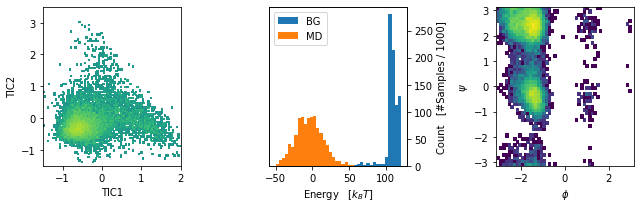

In [46]:
evaluate_generator(generator, samples)

In [217]:
widget.clear()

In [218]:
selection = system._mdtraj_topology.select("resid == 8")

In [219]:
widget.add_representation("licorice", selection=selection)

In [47]:
generator_metrics(valdata = valdata[:10])

Validation NLL -1468.51
Validation U (1st quantile) 1.27e+03
Validation U (median) 8.04e+04
Validation U (3rd quantile) 4.42e+08
Validation H 1483.36


train on NLL and KLL

In [ ]:
#generator._target = bg.LinLogCutEnergy(dataset.get_energy_model(n_workers=6), high_energy=100., max_energy=1000.)

In [25]:
#generator._target = bg.LinLogCutEnergy(dataset.get_energy_model(n_workers=6), high_energy=1000., max_energy=10000.)

In [34]:


optim = torch.optim.Adam(generator.parameters(), lr=1e-4)
scheduler = ExponentialLR(optim, gamma=0.7)
KLL = []
NLL = []
#U = []
#U_limited = []
#H = []
from tqdm.auto import tqdm
import time
tic=time.time()
#n_epochs = 30
w_energy=0.1
w_likelihood = 1 - w_energy
clip_forces = 20.0

params = [(1, 1e-12),(1,1e-6),(1, 1e-5),(1,1e-4),(1, 1e-3),(2,5e-3),(2,1e-2),(20,5e-2)]
params = [(1,1e-6),(1, 1e-5),(1,1e-4),(1, 1e-3),(2,5e-3),(2,1e-2),(20,5e-2)]
epochs = 0
#params = [(3, 0)]
params = [(1,1e-2),(1, 2e-2),(1,4e-2),(1, 1e-1),(1,2e-1),(1,4e-1),(1,8e-1)]
params = [(1,8e-1)]
kll = torch.Tensor([0])
nll = torch.Tensor([0])
for n_epochs, w_energy in params:
    w_likelihood = 1 - w_energy
    print(f'n_epochs:{n_epochs}, w_energy: {w_energy}')

    for epoch in tqdm(range(n_epochs)):
        lr = optim.param_groups[0]["lr"]
        print(f"lr: {lr}")

        print(f"Epoch {epochs}")
        epochs += 1
        trainloader = DataLoader(traindata, batch_size=256, shuffle=True)
        valloader = DataLoader(valdata, batch_size=1024, shuffle=True)

        for batch in tqdm(trainloader):
            #ipdb.set_trace()
            optim.zero_grad()
            
                        # aggregate weighted gradient
            #loss = nll
            #loss.backward()
            if w_energy > 0:
                kll = generator.kldiv(256).mean()
                l = w_energy / (w_likelihood + w_energy)
                (l * kll).backward(retain_graph = True)
            # constrain forces
                
                if clip_forces is not None:
                    torch.nn.utils.clip_grad_value_(generator.parameters(), clip_forces)

            
            
            
            # nll
            
            if w_likelihood > 0:
                nll = generator.energy(batch.to(**ctx)).mean()
                l = w_likelihood / (w_likelihood + w_energy)
                (l*nll).backward()
                #torch.autograd.grad(outputs=(l * nll),inputs=generator.parameters(), retain_graph = True)
            #nll.backward(retain_graph=True)

            #print("NLL", f"{nll.item():.2f}")

            # kll
 
            print("NLL", f"{nll.item():.2f}","KLL", f"{kll.item():.2f}", end="\r") 
            KLL.append(kll.item())# clip only kll
            NLL.append(nll.item())
            ## investigate U,H
          # with torch.no_grad():                
          #     u_limited=unnormalized_kl_div_U(generator._prior, generator._flow, generator._target, n_samples = 256)
          #     u=unnormalized_kl_div_U(generator._prior, generator._flow, target = target_real, n_samples = 256)
          #     h=unnormalized_kl_div_H(generator._prior, generator._flow, generator._target, n_samples = 256)

          # 
          # U_limited.append(u_limited.mean().item())
          # U.append(u.mean().item())
          # H.append(h.mean().item())

            optim.step()
        scheduler.step()
       # val_nll = [
       #     generator.energy(batch.to(**ctx)).detach().cpu() 
       #     for batch in valloader
       # ]
       # print(f"Validation NLL {torch.cat(val_nll).mean().item():.2f}")
toc=time.time()
print(F'training took {toc-tic} seconds.')

n_epochs:1, w_energy: 0.8


  0%|          | 0/1 [00:00<?, ?it/s]

lr: 0.0001
Epoch 0


  0%|          | 0/500 [00:00<?, ?it/s]

/home/marcel/anaconda3/envs/bgkraemer_clone/lib/python3.9/site-packages/bgflow-0.1-py3.9.egg/bgflow/nn/flow/crd_transform/ic_helper.py:283: UserWarning: singular division in torsion computation


training took 1266.1174840927124 seconds.


In [99]:
torch.save(generator.state_dict(), "nll+kll_science.pic")

In [141]:
generator.load_state_dict(torch.load("nll+kll_science.pic"))

<All keys matched successfully>

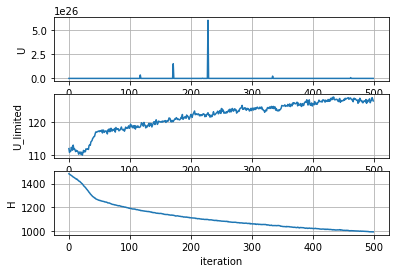

In [36]:

fig, axes = plt.subplots(3)
axes[0].plot(U)

axes[0].set(ylabel='U', xlabel='iteration')
axes[0].grid()

axes[1].plot(U_limited)

axes[1].set(ylabel='U_limited', xlabel='iteration')
axes[1].grid()

axes[2].plot(H)

axes[2].set(ylabel='H', xlabel='iteration')
axes[2].grid()


fig.savefig("U vs. H.png")
plt.show()

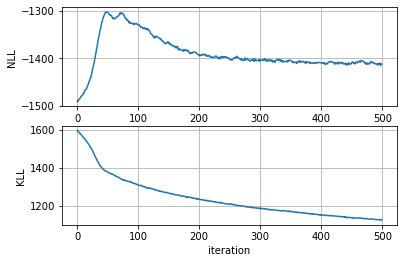

In [93]:

fig, axes = plt.subplots(2)
axes[0].plot(NLL)

axes[0].set(ylabel='NLL', xlabel='iteration')
axes[0].grid()

axes[1].plot(KLL)

axes[1].set(ylabel='KLL', xlabel='iteration')
axes[1].grid()


fig.savefig("KLL+NLL.png")
plt.show()

In [39]:
optim = torch.optim.Adam(generator.parameters(), lr=5e-6)

In [148]:
from torch.optim.lr_scheduler import ExponentialLR
scheduler = ExponentialLR(optim, gamma=0.7)
KLL = []
NLL = []
from tqdm.notebook import tqdm
#from tqdm import tqdm_notebook
import time
tic=time.time()
#n_epochs = 30

w_energy=0.2
w_likelihood = 1 - w_energy
clip_forces = True




params = [(2,1e-1),(2,5e-1),(2,9e-1)]
#params = [(20,1)]
epochs=0
#params = [(1, 1e-12)]
params = [(3,1)]

for n_epochs, w_energy in params:
    w_likelihood = 1 - w_energy
    print(f'n_epochs:{n_epochs}, w_energy: {w_energy}')

    for epoch in tqdm(range(n_epochs)):
        epochs += 1
        print(f"Epoch {epochs}")
        lr = optim.param_groups[0]["lr"]
        print(f"lr: {lr}")

        trainloader = DataLoader(traindata, batch_size=256, shuffle=True, drop_last=True)
        valloader = DataLoader(valdata, batch_size=1024, shuffle=True, drop_last=True)

        for batch in tqdm(trainloader):
            optim.zero_grad()

            # nll
            nll = generator.energy(batch.to(**ctx)).mean()
            #if w_likelihood > 0:
             #   l = w_likelihood / (w_likelihood + w_energy)
                #torch.autograd.grad(outputs=(l * nll),inputs=generator.parameters(), retain_graph = True)
            #nll.backward(retain_graph=True)

            #print("NLL", f"{nll.item():.2f}")

            # kll
            kll = generator.kldiv(256).mean()
            print("NLL", f"{nll.item():.2f}","KLL", f"{kll.item():.2f}", end="\r") 
            KLL.append(kll.item())
            NLL.append(nll.item())
            # aggregate weighted gradient
            loss = w_likelihood*nll+w_energy*kll
            loss.backward()
            #if w_energy > 0:
              #   l = w_energy / (w_likelihood + w_energy)
               # (l * kll).backward()
            # constrain forces
            if clip_forces is not None:
                torch.nn.utils.clip_grad_value_(generator.parameters(), clip_forces)

            optim.step()

        val_nll = [
            generator.energy(batch.to(**ctx)).detach().cpu() 
            for batch in valloader
        ]
        print(f"Validation NLL {torch.cat(val_nll).mean().item():.2f}")
        scheduler.step()
toc=time.time()
print(F'training took {toc-tic} seconds.')

n_epochs:3, w_energy: 1


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1
lr: 0.001


  0%|          | 0/500 [00:00<?, ?it/s]

AssertionError: 

In [149]:
torch.save(generator.state_dict(), "nll+kll_broken.pic")

In [130]:
#torch.save(generator.state_dict(), "nll+kll_latest.pic")

In [147]:
generator.load_state_dict(torch.load( "nll+kll_latest.pic"))

<All keys matched successfully>

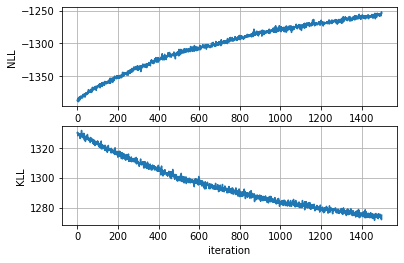

In [37]:

fig, axes = plt.subplots(2)
axes[0].plot(NLL)

axes[0].set(ylabel='NLL', xlabel='iteration')
axes[0].grid()

axes[1].plot(KLL)

axes[1].set(ylabel='KLL', xlabel='iteration')
axes[1].grid()


fig.savefig("KLL+NLL.png")
plt.show()

In [ ]:
KLL = []
NLL = []
from tqdm.auto import tqdm
import time
tic=time.time()
#n_epochs = 30
w_energy=0.1
w_likelihood = 1 - w_energy
clip_forces = True

#params = [(2,1e-1),(5,5e-1),(5,9e-1)]
params = [(20,1)]
epochs=0
#params = [(1, 1e-12)]
for n_epochs, w_energy in params:
    w_likelihood = 1 - w_energy
    print(f'n_epochs:{n_epochs}, w_energy: {w_energy}')

    for epoch in tqdm(range(n_epochs)):
        epochs += 1
        print(f"Epoch {epochs}")

        trainloader = DataLoader(traindata, batch_size=256, shuffle=True)
        valloader = DataLoader(valdata, batch_size=1024, shuffle=True)

        for batch in tqdm(trainloader):
            optim.zero_grad()

            # nll
            nll = generator.energy(batch.to(**ctx)).mean()
            #if w_likelihood > 0:
             #   l = w_likelihood / (w_likelihood + w_energy)
                #torch.autograd.grad(outputs=(l * nll),inputs=generator.parameters(), retain_graph = True)
            #nll.backward(retain_graph=True)

            #print("NLL", f"{nll.item():.2f}")

            # kll
            kll = generator.kldiv(256).mean()
            print("NLL", f"{nll.item():.2f}","KLL", f"{kll.item():.2f}", end="\r") 
            KLL.append(kll.item())
            NLL.append(nll.item())
            # aggregate weighted gradient
            loss = w_likelihood*nll+w_energy*kll
            loss.backward()
            #if w_energy > 0:
              #   l = w_energy / (w_likelihood + w_energy)
               # (l * kll).backward()
            # constrain forces
            if clip_forces is not None:
                torch.nn.utils.clip_grad_value_(generator.parameters(), clip_forces)

            optim.step()

        val_nll = [
            generator.energy(batch.to(**ctx)).detach().cpu() 
            for batch in valloader
        ]
        print(f"Validation NLL {torch.cat(val_nll).mean().item():.2f}")
toc=time.time()
print(F'training took {toc-tic} seconds.')

In [ ]:
torch.save(generator.state_dict(), "nll+kll_science_1.pic")

In [ ]:

fig, axes = plt.subplots(2)
axes[0].plot(NLL)

axes[0].set(ylabel='NLL', xlabel='iteration')
axes[0].grid()

axes[1].plot(KLL)

axes[1].set(ylabel='KLL', xlabel='iteration')
axes[1].grid()


fig.savefig("KLL+NLL.png")
plt.show()

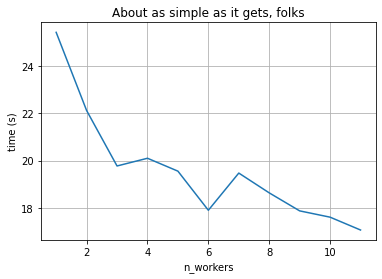

In [34]:
t = np.arange(1,12)
fig, ax = plt.subplots()
ax.plot(t, times)

ax.set(ylabel='time (s)', xlabel='n_workers',
       title='About as simple as it gets, folks')
ax.grid()

fig.savefig("benchmark_multiprocessing.png")
plt.show()

In [37]:
ctx

{'device': device(type='cpu'), 'dtype': torch.float32}

In [39]:
ctx.__dict__

AttributeError: 'dict' object has no attribute '__dict__'